In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from sklearn.metrics import mean_squared_error, classification_report, precision_recall_curve
import seaborn as sns
from tqdm import tqdm
from xgboost import XGBClassifier

In [2]:
%%time
df = pd.read_csv('dep_delay_df.csv')
df.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
df.FIRST_DEP_TIME.fillna(0, inplace=True)
df.TOTAL_ADD_GTIME.fillna(0, inplace=True)
df.LONGEST_ADD_GTIME.fillna(0, inplace=True)
df.STD_DELAY.fillna(0, inplace=True)
df.MEAN_DELAY.fillna(0, inplace=True)
df.MAX_DELAY.fillna(0, inplace=True)
df.MIN_DELAY.fillna(0, inplace=True)
df.COUNT.fillna(0, inplace=True)
df['25%_DELAY'].fillna(0, inplace=True)
df['50%_DELAY'].fillna(0, inplace=True)
df['75%_DELAY'].fillna(0, inplace=True)
df.dropna(inplace=True)

CPU times: user 32.2 s, sys: 15.6 s, total: 47.8 s
Wall time: 53.7 s


In [3]:
df.shape

(4738774, 54)

In [4]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,75%_DELAY,MAX_DELAY,WEEKEND,LATE_AIRLINE_INDEX,LATE_TAIL_INDEX,LATE_ARR,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4
0,4,23,4,630622,364063,165,593194,626612,901400,738857,...,-0.50,20.0,0,0.239771,0.233333,0.0,0.0,0.0,0.0,0.0
1,4,24,5,630622,879451,165,593194,626612,901400,738857,...,12.00,140.0,0,0.239771,0.270298,0.0,1.0,1.0,0.0,0.0
2,4,25,6,630622,833150,165,593194,626612,901400,738857,...,-0.50,51.0,1,0.239771,0.257855,0.0,0.0,1.0,0.0,0.0
3,4,26,7,630622,784414,165,593194,626612,901400,738857,...,15.50,128.0,1,0.239771,0.269641,0.0,0.0,1.0,1.0,0.0
4,4,27,1,630622,923562,165,593194,626612,901400,738857,...,2.25,94.0,0,0.239771,0.229491,1.0,1.0,1.0,0.0,0.0


In [5]:
def fill_dep_delay(x):
    if x >= 15:
        return 1
    return 0

In [6]:
df['DEP_DELAY'] = df['DEP_DELAY'].apply(fill_dep_delay)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
#scaler = StandardScaler()

#df = df[df.DEP_DELAY==0]
y = df.DEP_DELAY
df.drop('DEP_DELAY', axis=1, inplace=True)
#y = df.CANCELLED
#df.drop('CANCELLED', axis=1, inplace=True)

df = scaler.fit_transform(df)

x_train, x_test, y_train, y_test = train_test_split(df, y, shuffle=True, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, random_state=42, stratify=y_train)

In [8]:
x_train.shape

(2665560, 53)

In [9]:
x_train[y_train==0].shape

(2178776, 53)

In [23]:
def create_dense_ae():
    encoding_dim = 25

    # Энкодер
    input_img = Input(shape=(x_train.shape[1],))
    flat_img = Flatten()(input_img)
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(x_train.shape[1], activation='sigmoid')(input_encoded)
    decoded = Reshape((x_train.shape[1],))(flat_decoded)

    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [24]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [25]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
encoder (Functional)         (None, 25)                1275      
_________________________________________________________________
decoder (Functional)         (None, 50)                1300      
Total params: 2,575
Trainable params: 2,575
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test[y_test==0], x_test[y_test==0]))

Epoch 1/50
7700/7700 [==============================] - 14s 2ms/step - loss: 0.4013 - val_loss: 0.3656
Epoch 2/50
7700/7700 [==============================] - 14s 2ms/step - loss: 0.3660 - val_loss: 0.3653
Epoch 3/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3657 - val_loss: 0.3652
Epoch 4/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3656 - val_loss: 0.3651
Epoch 5/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3655 - val_loss: 0.3650
Epoch 6/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3654 - val_loss: 0.3650
Epoch 7/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3654 - val_loss: 0.3650
Epoch 8/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3654 - val_loss: 0.3650
Epoch 9/50
7700/7700 [==============================] - 13s 2ms/step - loss: 0.3654 - val_loss: 0.3650
Epoch 10/50
7700/7700 [==============================] - 13s 2ms/step - l

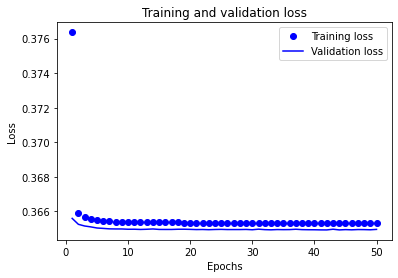

In [27]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 50 + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()

In [9]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(x_train.shape[1], activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train[y_train==0], x_train[y_train==0], epochs=15, batch_size=256,
         validation_data=(x_test[y_test==0], x_test[y_test==0]))

Epoch 1/15
8511/8511 [==============================] - 35s 4ms/step - loss: 0.3939 - val_loss: 0.3681
Epoch 2/15
8511/8511 [==============================] - 30s 4ms/step - loss: 0.3676 - val_loss: 0.3664
Epoch 3/15
8511/8511 [==============================] - 30s 4ms/step - loss: 0.3658 - val_loss: 0.3650
Epoch 4/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3650 - val_loss: 0.3648
Epoch 5/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3648 - val_loss: 0.3648
Epoch 6/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3648 - val_loss: 0.3647
Epoch 7/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3648 - val_loss: 0.3647
Epoch 8/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3649 - val_loss: 0.3646
Epoch 9/15
8511/8511 [==============================] - 31s 4ms/step - loss: 0.3648 - val_loss: 0.3647
Epoch 10/15
8511/8511 [==============================] - 31s 4ms/step - l

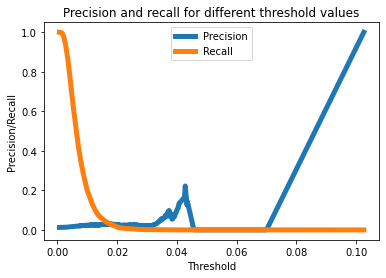

In [26]:
valid_x_predictions = model.predict(x_val)
mse = np.mean(np.power(x_val - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [10]:
test_x_predictions = model.predict(x_test)
mse = x_test - test_x_predictions

In [11]:
mse.shape

(1184694, 53)

In [12]:
%%time
grad = XGBClassifier(random_state=42, n_jobs=6, use_label_encoder=False)
grad.fit(mse, y_test)

[22:17:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 54min 17s, sys: 2.64 s, total: 54min 20s
Wall time: 9min 3s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [13]:
valid_x_predictions = model.predict(x_val)
mse = x_val - valid_x_predictions
print(classification_report(y_val, grad.predict(mse)))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91    726259
           1       0.65      0.42      0.51    162261

    accuracy                           0.85    888520
   macro avg       0.77      0.68      0.71    888520
weighted avg       0.84      0.85      0.84    888520



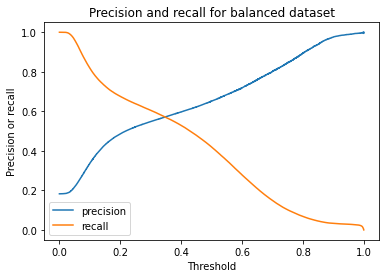

In [14]:
precision, recall, thresholds = precision_recall_curve(y_val, grad.predict_proba(mse)[:, 1])
thresholds = [0] + thresholds.tolist()
plt.plot(thresholds, precision, label='precision');
plt.plot(thresholds, recall, label='recall');
plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Precision or recall');
plt.title('Precision and recall for balanced dataset');

In [15]:
def asd(x):
    if x > 0.3:
        return 1
    return 0

In [16]:
p_network = grad.predict_proba(mse)[:, 1]

In [23]:
prediction = []
for i in tqdm(range(len(x_val))):
    if p_network[i] < 0.3:
        prediction.append(0)
    else:
        prediction.append(1)

100%|██████████| 888520/888520 [00:03<00:00, 254504.42it/s]


In [24]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    726259
           1       0.55      0.60      0.58    162261

    accuracy                           0.84    888520
   macro avg       0.73      0.75      0.74    888520
weighted avg       0.84      0.84      0.84    888520



In [18]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

use_regularizer = True
my_regularizer = None
my_epochs = 15
features_path = 'simple_autoe_features.pickle'
labels_path = 'simple_autoe_labels.pickle'

if use_regularizer:
    my_regularizer = regularizers.l1(10e-8)
    my_epochs = 50
    features_path = 'sparse_autoe_features.pickle'
    labels_path = 'sparse_autoe_labels.pickle'

encoding_dim = 25

input_img = Input(shape=(x_train.shape[1], ))

encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)

decoded = Dense(x_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

autoencoder.fit(x_train[y_train==0], x_train[y_train==0], 
                epochs=my_epochs, batch_size=128, shuffle=True)#, validation_data=(x_test, x_test))

Epoch 1/50
17022/17022 [==============================] - 37s 2ms/step - loss: 0.3643
Epoch 2/50
17022/17022 [==============================] - 37s 2ms/step - loss: 0.3461
Epoch 3/50
17022/17022 [==============================] - 37s 2ms/step - loss: 0.3460
Epoch 4/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3459
Epoch 5/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3459
Epoch 6/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3459
Epoch 7/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3459
Epoch 8/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3458
Epoch 9/50
17022/17022 [==============================] - 37s 2ms/step - loss: 0.3458
Epoch 10/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3458
Epoch 11/50
17022/17022 [==============================] - 36s 2ms/step - loss: 0.3458
Epoch 12/50
17022/17022 [===========================

In [19]:
test_x_predictions = autoencoder.predict(x_test)
mse = x_test - test_x_predictions

In [20]:
%%time
grad = XGBClassifier(random_state=42, n_jobs=6, use_label_encoder=False)
grad.fit(mse, y_test)

[18:02:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 57min 13s, sys: 5.43 s, total: 57min 19s
Wall time: 9min 35s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
valid_x_predictions = autoencoder.predict(x_val)
mse = x_val - valid_x_predictions
print(classification_report(y_val, grad.predict(mse)))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91    726259
           1       0.66      0.37      0.47    162261

    accuracy                           0.85    888520
   macro avg       0.76      0.66      0.69    888520
weighted avg       0.83      0.85      0.83    888520



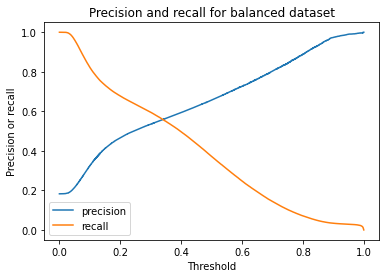

In [22]:
precision, recall, thresholds = precision_recall_curve(y_val, grad.predict_proba(mse)[:, 1])
thresholds = [0] + thresholds.tolist()
plt.plot(thresholds, precision, label='precision');
plt.plot(thresholds, recall, label='recall');
plt.legend(); plt.xlabel('Threshold'); plt.ylabel('Precision or recall');
plt.title('Precision and recall for balanced dataset');

In [23]:
p_network = grad.predict_proba(mse)[:, 1]

In [24]:
prediction = []
for i in tqdm(range(len(x_val))):
    if p_network[i] < 0.31:
        prediction.append(0)
    else:
        prediction.append(1)

100%|██████████| 888520/888520 [00:03<00:00, 241161.08it/s]


In [25]:
print(classification_report(y_val, prediction))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90    726259
           1       0.54      0.59      0.56    162261

    accuracy                           0.83    888520
   macro avg       0.72      0.74      0.73    888520
weighted avg       0.84      0.83      0.84    888520

